In [30]:
import numpy as np
import pandas as pd
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from sqlalchemy import create_engine
import psycopg2
import plotly.figure_factory as ff
import plotly.express as px 
import os 
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')

In [22]:
engine = create_engine("postgresql+psycopg2://{user}:{pw}@{service}:{port}/{db}".format(
    user = 'postgres', 
    pw = POSTGRES_PASSWORD, 
    service= "postgres",
    port=5432, 
    db = 'congress', 
))

In [23]:
myquery = '''
SELECT directordername, bioguideid 
FROM members
ORDER BY lastname 
'''

members = pd.read_sql_query(myquery, con=engine)
memberslist = [{"label":x,'value':y} for x,y in zip(members['directordername'], members["bioguideid"])]

In [24]:
members

,directordername,bioguideid
0,Alma S. Adams,A000370
1,Robert B. Aderholt,A000055
2,Pete Aguilar,A000371
3,Mark Alford,A000379
4,Rick W. Allen,A000372
...,...,...
525,Steve Womack,W000809
526,Ron Wyden,W000779
527,Rudy Yakym III,Y000067
528,Todd Young,Y000064


In [33]:
#ideology not added... need to update but had issues with new data
myquery = '''
SELECT directordername,
        party,
        state,
        district
FROM members m
'''
 
ideo_df = pd.read_sql_query(myquery, engine)
ideo_df['chamber'] = ideo_df['district'].isnull()
ideo_df['chamber'] = ideo_df['chamber'].replace({True:'Senate', False: 'House of Representatives'})

In [28]:
ideo_df ["namedistrict"] = [n + ' (' + s + ')' if c =='Senate' else n + ' (' + s + ' - ' + str(int(d)) + ')' for n, s, c, d in zip(ideo_df['directordername'], ideo_df['state'], ideo_df['chamber'], ideo_df['district'])]
ideo_df['party'] = ideo_df['party'].

In [34]:
def ideograph(b):
    ideo2 = ideo_df.query(f'bioguideid == ')

fig = px.scatter(ideo_df, x='ideology', y='chamber', color='party',
                 color_discrete_map={'Republican': 'red',
                                     'Democrat': 'blue',
                                     'Independent': 'green'},
                 height=300, width=600,
                 labels={'ideology':'Left/Right Ideology (DW-NOMINATE)', 
                        'chamber':'Chamber',
                        'party': 'Political Party'},
                 hover_name = 'namedistrict',
                 hover_data=['party'],
                 title = 'Ideological Placements in Congress',
                opacity = .1)

 

fig.update(layout=dict(title=dict(x=0.5)))
fig.update_yaxes(range=(-0.5, 1.5), tickvals=[0, 1],
                ticktext = ['Senate', 'House of Representatives'])
fig.update_xaxes(range=(-1,1), tickvals=[-1, -.5, 0, .5, 1],
                ticktext = ['Extreme left', 'Moderate left', 'Centrist', 'Moderate right', 'Extreme right'])

 

fig.add_traces(
    px.scatter(ideo2, x='ideology', y='chamber', color='party',
                 color_discrete_map={'Republican': 'red',
                                     'Democrat': 'blue',
                                     'Independent': 'green'},
                 height=300, width=600,
                 labels={'ideology':'Left/Right Ideology (DW-NOMINATE)', 
                        'chamber':'Chamber',
                        'party': 'Political Party'},
                 hover_name = 'namedistrict',
                 hover_data=['party'],
                 title = 'Ideological Placements in Congress').update_traces(marker=dict(size=8, symbol="star", line=dict(width=2, color="DarkSlateGrey")),
                                                                            showlegend=False).data
)

 


return [fig]

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['directordername', 'party', 'state', 'district', 'chamber'] but received: ideology

In [5]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [6]:
mymarkdown = '''
Congressional elections are usually all about the big, national issues, but the representatives and the senators work for local districts and states. Not all issues are the same everywhere. The purpose of this dashboard is to collect public data from these sources: 

    * [Official API for the U.S. Congress](https://api.congress.gov)
    * [Voteview](https://voteview.com)
    * [Open Secrets](https://www.opensecrets.org/open-data/api)
'''

In [7]:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.layout = html.Div(
    [
        # stuff on top 
        html.H1("Know Your Respresentatives in Congress"), 
        html.H2('Data collected from APIs from Congress.gov, Open Secrets, Voteview.com, and ProPublica'),
        html.H3('DS 6600: Data Engineering 1, UVA Data Science'),
        # side bar 
        html.Div([
            dcc.Markdown("Please select a Representative or Senator"),
            dcc.Dropdown(id = 'member',
                        options = memberslist,
                        value = "A000370"),
            dcc.Markdown(mymarkdown),
            
        ],style = {'width':'24%', 'float':'left'}),
        # main bar
        html.Div([
            dcc.Tabs([
               dcc.Tab(label = 'Biographical Info', children = [
                    # stuff for bio tab goes here
                    html.Div([html.Img(id = 'bioimage', style={'height':'100%', 'width':'100%'})], style = {'width': '24%', 'float':'left'}),
                    html.Div([dcc.Graph(id = 'biotable')], style = {'width': '74%', 'float':'right'})
                ]),
                dcc.Tab(label = 'Bill Sponsorship', children = [
                   # stuff for bill tab goes here
                   
               ]),
                dcc.Tab(label = 'Voting and Ideology', children = [
                   # stuff for voting tab goes here
                   
               ]),
                dcc.Tab(label = 'Donors and Financial Info', children = [
                   # stuff for donors tab goes here
                   
               ]),
                
            
                
            ])
            
        ],style = {'width':'74%', 'float':'right'})
        
    ]
)


@app.callback([Output(component_id = 'biotable', component_property = 'figure')],
             [Input(component_id = 'member',component_property = 'value')])

def biotable(b):
    myquery = f'''
    SELECT  directordername AS Name,
        party AS Party,
        state AS State,
        CAST(district AS int) AS District,
        birthyear AS Birthyear,
        addressinformation_officeaddress AS Address,
        CONCAT(addressinformation_city, ' , ' , addressinformation_district) AS City,
        addressinformation_zipcode AS Zipcode,
        addressinformation_phonenumber AS Phone 
        
    FROM members 
    WHERE bioguideid = '{b}'
    '''
    mydf = pd.read_sql_query(myquery, con = engine)#.T.reset_index()
    mydf.columns = [x.capitalize() for x in mydf.columns]
    mydf = mydf.T.reset_index()
    mydf = mydf.rename({'index':'',0:''},axis = 1)
    return [ff.create_table(mydf)]

@app.callback([Output(component_id = 'bioimage', component_property = 'src')],
             [Input(component_id = 'member', component_property = 'value')])

def bioimage(b):
    myquery = f'''
    SELECT depiction_imageurl
    FROM members
    WHERE bioguideid='{b}'
    '''
    mydf = pd.read_sql_query(myquery, con=engine)
    return [mydf['depiction_imageurl'][0]]

if __name__== "__main__":
    app.run(mode= 'external', host='0.0.0.0', port = 8050, debug=False)

In [8]:

def biotable(b):
    myquery = f'''
    SELECT  directordername AS Name,
        party AS Party,
        state AS State,
        CAST(district AS int) AS District,
        birthyear AS Birthyear,
        addressinformation_officeaddress AS Address,
        CONCAT(addressinformation_city, ' , ' , addressinformation_district) AS City,
        addressinformation_zipcode AS Zipcode,
        addressinformation_phonenumber AS Phone 
        
    FROM members 
    WHERE bioguideid = '{b}'
    '''
    mydf = pd.read_sql_query(myquery, con = engine)#.T.reset_index()
    mydf.columns = [x.capitalize() for x in mydf.columns]
    mydf = mydf.T.reset_index()
    mydf = mydf.rename({'index':'',0:''},axis = 1)
    return ff.create_table(mydf)

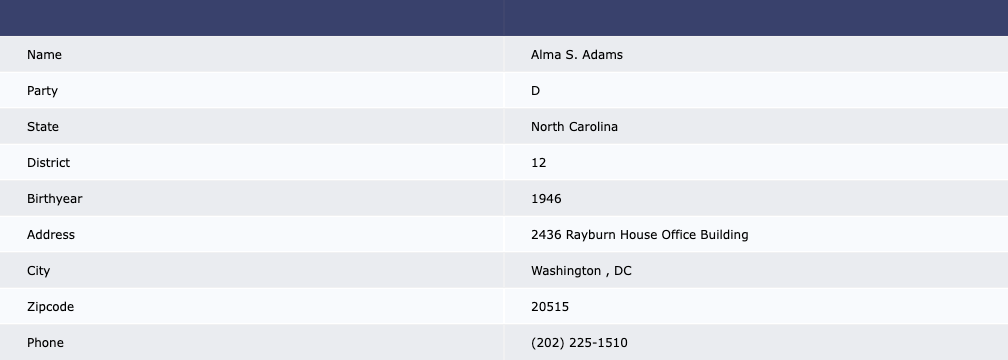

In [61]:
biotable('A000370')